In [1]:
import sys

sys.path.remove('/usr/local/lib/python3.9/site-packages')
sys.path.append('/usr/local/lib/python3.7/site-packages')

In [2]:
import os
import glob
import pickle
import shutil
import datetime

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import linear_model
from PIL import Image
import cv2
from scipy.stats import gaussian_kde

import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.preprocessing.image import array_to_img, img_to_array

Using TensorFlow backend.


# Data preprocessing

## Set hyperparameters

In [3]:
PATCH_SIZE = 125
PATCH_MARGIN = PATCH_SIZE//2
CHANNEL_NUM = 3

SPACING = 40

h = 1193
w = 1723

val_h_threshold = h // 4
val_w_threshold = w // 2

test_h_threshold = h // 2
test_w_threshold = w // 2

In [4]:
num_rows = (h - (PATCH_SIZE//2)*2) // SPACING
num_cols = (w - (PATCH_SIZE//2)*2) // SPACING
print(num_rows * num_cols) # Number of all patches

1014


## Feature extraction and standarlization

In [4]:
def cal_ndvi(img_r, img_ir):
    return (img_ir - img_r) / (img_ir + img_r + (1e-7)) # avoid zero division error

def standarlization(img_2d):
    return (img_2d - np.min(img_2d)) / (np.max(img_2d) - np.min(img_2d))

def feature_extraction(img):
    img_ndvi = cal_ndvi(img[4], img[5])
    img_vh = standarlization(img[0])
    img_vv = standarlization(img[1])
    img_elev = standarlization(img[6])
#     img_ndvi_modis = cal_ndvi(img[7], img[8])
#     img_std = np.array([img_ndvi, img_vh, img_vv, img_elev, img_ndvi_modis])
    img_std = np.array([img_ndvi, img_vh, img_vv, img_elev])
    return img_std

def feature_extraction_modis(img):
    img_ndvi = cal_ndvi(img[4], img[5])
    img_vh = standarlization(img[0])
    img_vv = standarlization(img[1])
    img_elev = standarlization(img[6])
    img_terra_ndvi = cal_ndvi(img[7], img[8])
    img_aqua_ndvi = cal_ndvi(img[9], img[10])
    img_std = np.array([img_ndvi, img_vh, img_vv, img_elev, img_terra_ndvi, img_aqua_ndvi])
    return img_std

def feature_extraction_modis_single(img):
    img_ndvi = cal_ndvi(img[4], img[5])
    img_vh = standarlization(img[0])
    img_vv = standarlization(img[1])
    img_elev = standarlization(img[6])
    img_terra_ndvi = cal_ndvi(img[7], img[8])
    img_std = np.array([img_ndvi, img_vh, img_vv, img_elev, img_terra_ndvi])
    return img_std

## Generate patch

In [5]:
def generate_patch(img, SPACING=SPACING):
    
    img_std = feature_extraction(img)
    
    train_patch = []
    val_patch = []
    test_patch = [] # For temporary test (Actual test uses patch with spacing=1)

    for i in range(num_rows):
        for j in range(num_cols):

            start_h = i*SPACING
            end_h = PATCH_SIZE+i*SPACING
            start_w = j*SPACING
            end_w = PATCH_SIZE+j*SPACING
            img_extracted = img_std[:,start_h:end_h, start_w: end_w]
            
            if end_h <= val_h_threshold or end_w <= val_w_threshold:
                train_patch.append(img_extracted)
            elif end_h <= test_h_threshold or end_w <= test_w_threshold:
                val_patch.append(img_extracted)
            else:
                test_patch.append(img_extracted)

    train_patch = np.array(train_patch)
    val_patch = np.array(val_patch)
    test_patch = np.array(test_patch)

    print(train_patch.shape)
    print(val_patch.shape)
    print(test_patch.shape)
    
    return train_patch, val_patch, test_patch


def generate_all_patch(img, SPACING=SPACING):
    
    h = img.shape[1]
    w = img.shape[2]
    
    num_rows = (h - (PATCH_SIZE//2)*2) // SPACING
    num_cols = (w - (PATCH_SIZE//2)*2) // SPACING
    
    img_std = feature_extraction(img)
    
    all_patch = []

    for i in range(num_rows):
        for j in range(num_cols):

            start_h = i*SPACING
            end_h = PATCH_SIZE+i*SPACING
            start_w = j*SPACING
            end_w = PATCH_SIZE+j*SPACING
            img_extracted = img_std[:,start_h:end_h, start_w: end_w]
            all_patch.append(img_extracted)

    all_patch = np.array(all_patch)

    print(all_patch.shape)
    
    return all_patch


def generate_all_patch_modis(img, mod_ndvi, SPACING=SPACING):
    
    h = img.shape[1]
    w = img.shape[2]
    
    num_rows = (h - (PATCH_SIZE//2)*2) // SPACING
    num_cols = (w - (PATCH_SIZE//2)*2) // SPACING
    
    img_std = feature_extraction_modis_single(img)
    img_std[4,:,:] = mod_ndvi
    # img_std = feature_extraction_modis(img)
    
    all_patch = []

    for i in range(num_rows):
        for j in range(num_cols):

            start_h = i*SPACING
            end_h = PATCH_SIZE+i*SPACING
            start_w = j*SPACING
            end_w = PATCH_SIZE+j*SPACING
            img_extracted = img_std[:,start_h:end_h, start_w: end_w]
            all_patch.append(img_extracted)

    all_patch = np.array(all_patch)

    print(all_patch.shape)
    
    return all_patch


def augmentate_patch(x_patch, y_patch):
    return (x_patch, np.flipud(x_patch), np.fliplr(x_patch), np.flipud(np.fliplr(x_patch))), (y_patch, np.flipud(y_patch), np.fliplr(y_patch), np.flipud(np.fliplr(y_patch)))

### Train-test patch

In [150]:
city  = 'otofuke'
save_dir = f'../sar_2_ndvi/{city}/bin/patch_sr/125'
img_list = glob.glob(f'../sar_2_ndvi/{city}/bin/pixel_resized/collocate_crop_nn*.npy')

# img_list = list(filter(lambda x: 'cloud' not in x, img_list))

for i, path in enumerate(img_list):
    
    print(path)
    idx = path[-8:-4]
    img = np.load(path)
    img = img[:7]
    
    train_patch, val_patch, test_patch = generate_patch(img)

    for patch_array, label in zip([train_patch, val_patch, test_patch], ['train', 'val', 'test']):
        X_array = []
        y_array = []
        for patch in patch_array:
            X, y = patch_2_input(patch, scale=25)
            X_array.append(X)
            y_array.append(y)

        X_array = np.array(X_array).astype(np.float32).transpose(0,2,3,1)
        y_array = np.array(y_array).astype(np.float32)[:, :, :, np.newaxis]
        
        os.makedirs(os.path.join(save_dir, idx), exist_ok=True)
        np.save(os.path.join(save_dir, f'{idx}/X_{label}.npy'), X_array)
        np.save(os.path.join(save_dir, f'{idx}/y_{label}.npy'), y_array)

### All patch

In [108]:
# save separately as binary file and load with keras generator

city  = 'biei'
save_dir = f'../sar_2_ndvi/{city}/bin/patch_sr'
img_list = glob.glob(f'../sar_2_ndvi/{city}/bin/pixel_resized/*.npy')
img_list = list(filter(lambda x: '_19_' in x, img_list))

for i, path in enumerate(img_list):
    
    print(path)
    idx = path[-8:-4]
    img = np.load(path)
    img = img[:7]
    
    all_patch = generate_all_patch(img)

    X_array = []
    y_array = []
    for num, patch in enumerate(all_patch):
        X, y = patch_2_input(patch, scale=25) # For nearest neighbor
#         X, y = patch_2_input_bilinear(patch, scale=25) # For bilinear
        
        X = np.array(X).astype(np.float32).transpose(1,2,0)
        y = np.array(y).astype(np.float32)[:, :, np.newaxis]
        
        num = str(num).zfill(7)
        np.save(os.path.join(save_dir, f'all/X_19_{idx}_{num}.npy'), X)
        np.save(os.path.join(save_dir, f'all/y_19_{idx}_{num}.npy'), y)

In [81]:
# save separately as binary file, with data augmentation

city  = 'tsumagoi'
save_dir = f'../sar_2_ndvi/{city}/bin_19/patch_sr/125'
img_list = glob.glob(f'../sar_2_ndvi/{city}/bin_19/pixel_resized/*.npy')
# img_list = list(filter(lambda x: '_19_' in x, img_list))

for i, path in enumerate(img_list):
    
    print(path)
    idx = path[-8:-4]
    img = np.load(path)
    img = img[:7]
    
    all_patch = generate_all_patch(img)

    X_array = []
    y_array = []
    for num, patch in enumerate(all_patch):
        X, y = patch_2_input(patch, scale=25) # For nearest neighbor
        X = np.array(X).astype(np.float32).transpose(1,2,0)
        y = np.array(y).astype(np.float32)[:, :, np.newaxis]
            
        X_subset, y_subset = augmentate_patch(X, y)
        
        for X, y, label in zip(X_subset, y_subset, ['', 'ud', 'lr', 'udlr']):
        
            num = str(num).zfill(7)
            np.save(os.path.join(save_dir, f'all/X_19_{idx}_{num}_{label}.npy'), X)
            np.save(os.path.join(save_dir, f'all/y_19_{idx}_{num}_{label}.npy'), y)

../sar_2_ndvi/tsumagoi/bin_19/pixel_resized/collocate_nn_19_cloud_0812.npy
(78, 4, 125, 125)
../sar_2_ndvi/tsumagoi/bin_19/pixel_resized/collocate_nn_19_0508.npy
(242, 4, 125, 125)
../sar_2_ndvi/tsumagoi/bin_19/pixel_resized/collocate_nn_19_cloud_0917.npy
(78, 4, 125, 125)
../sar_2_ndvi/tsumagoi/bin_19/pixel_resized/collocate_nn_19_1210.npy
(242, 4, 125, 125)
../sar_2_ndvi/tsumagoi/bin_19/pixel_resized/collocate_nn_19_0309.npy
(242, 4, 125, 125)
../sar_2_ndvi/tsumagoi/bin_19/pixel_resized/collocate_nn_19_0929.npy
(242, 4, 125, 125)
../sar_2_ndvi/tsumagoi/bin_19/pixel_resized/collocate_nn_19_0108.npy
(242, 4, 125, 125)
../sar_2_ndvi/tsumagoi/bin_19/pixel_resized/collocate_nn_19_0120.npy
(242, 4, 125, 125)
../sar_2_ndvi/tsumagoi/bin_19/pixel_resized/collocate_nn_19_1023.npy
(242, 4, 125, 125)
../sar_2_ndvi/tsumagoi/bin_19/pixel_resized/collocate_nn_19_0213.npy
(242, 4, 125, 125)
../sar_2_ndvi/tsumagoi/bin_19/pixel_resized/collocate_nn_19_cloud_0414.npy
(98, 4, 125, 125)


In [49]:
# Test patch (Sentinel)
# test_idx_list = ['0325','0524','0605','0804','0828','1027','1120'] # otofuke
# test_idx_list = ['0127','0303','0327','0420','0502','0818','1005','1110','1204'] # tsumagoi
# test_idx_list = ['0328','0421','0503','0608','0620','0924','1123'] # niigata
# test_idx_list = ['0329','0528','0727','0901','0925','1031','1124'] # otofuke_s1a
test_idx_list = ['0415', '0602', '0930'] # biei

# test_idx_list = ['0508','0812','0917','0929','1023','1210'] # tsumagoi 2019
# test_idx_list = ['0506','0729','1102','0424'] # otofuke 2019
# test_idx_list = ['0415','0509','0708','0906'] # niigata 2019
# test_idx_list = ['0310', '0626', '0825', '0906'] # oushu2019

city  = 'biei'

img_list = glob.glob(f'../sar_2_ndvi/{city}/bin/pixel_resized/collocate*.npy')
# img_list = list(filter(lambda x: '_19_' not in x, img_list))
save_dir = f'../sar_2_ndvi/{city}/bin/patch_sr'

for idx in test_idx_list:
    path= list(filter(lambda x: idx in x, img_list))[0]
    print(path)
    idx = path[-8:-4]
    img = np.load(path)
    img = img[:7]
    
    all_patch = generate_all_patch(img)

    X_array = []
    y_array = []
    for num, patch in enumerate(all_patch):
        X, y = patch_2_input(patch, scale=25)
#         X, y = patch_2_input_bilinear(patch, scale=25) # For bilinear
        X_array.append(X)
        y_array.append(y)
        
    X_array = np.array(X_array).astype(np.float32).transpose(0,2,3,1)
    y_array = np.array(y_array).astype(np.float32)[:, :, :, np.newaxis]
        
    num = str(num).zfill(7)
    np.save(os.path.join(save_dir, f'test/X_{idx}.npy'), X_array)
    np.save(os.path.join(save_dir, f'test/y_{idx}.npy'), y_array)

../sar_2_ndvi/biei/bin/pixel_resized/collocate_0415.npy
(1247, 4, 125, 125)
../sar_2_ndvi/biei/bin/pixel_resized/collocate_0602.npy
(1247, 4, 125, 125)
../sar_2_ndvi/biei/bin/pixel_resized/collocate_0930.npy
(1247, 4, 125, 125)


In [298]:
# Test patch (Modis)
# test_idx_list = ['0325','0524','0605','0804','0828','1027','1120'] # otofuke
# test_idx_list = ['0127','0303','0420','0502','0818','1005','1110','1204'] # tsumagoi +'0327'
# test_idx_mod_list = ['0126','0303','0425','0502','0820','1002','1108','1201'] # tsumagoi

city  = 'tsumagoi'
save_dir = f'../sar_2_ndvi/{city}/bin/patch_sr/125'

img_list = glob.glob(f'../sar_2_ndvi/{city}/bin/pixel_resized/collocate*.npy')

for idx, mod_idx in zip(test_idx_list, test_idx_mod_list):
    path= list(filter(lambda x: idx in x, img_list))[0]
    print(path)
    idx = path[-8:-4]
    img = np.load(path)
    img = img[:9]
    
    mod_ndvi = np.load(f'/Users/ryotanomura/沖研/satellite/sar_2_ndvi/{city}/modis_test/bin/ensemble/collocate_{mod_idx}.npy')
    all_patch = generate_all_patch_modis(img, mod_ndvi)

    X_array = []
    y_array = []
    for num, patch in enumerate(all_patch):
        X, y = patch_2_input_modis(patch, scale=25)
#         X, y = patch_2_input_bilinear(patch, scale=25) # For bilinear
        X_array.append(X)
        y_array.append(y)
        
    X_array = np.array(X_array).astype(np.float32).transpose(0,2,3,1)
    y_array = np.array(y_array).astype(np.float32)[:, :, :, np.newaxis]
        
    num = str(num).zfill(7)
    np.save(os.path.join(save_dir, f'test_modis/X_{idx}.npy'), X_array)
    np.save(os.path.join(save_dir, f'test_modis/y_{idx}.npy'), y_array)

../sar_2_ndvi/tsumagoi/bin/pixel_resized/collocate_nn_0127.npy
(242, 5, 125, 125)
../sar_2_ndvi/tsumagoi/bin/pixel_resized/collocate_nn_0303.npy
(242, 5, 125, 125)
../sar_2_ndvi/tsumagoi/bin/pixel_resized/collocate_nn_0420.npy
(242, 5, 125, 125)
../sar_2_ndvi/tsumagoi/bin/pixel_resized/collocate_nn_0502.npy
(242, 5, 125, 125)
../sar_2_ndvi/tsumagoi/bin/pixel_resized/collocate_nn_0818.npy
(242, 5, 125, 125)
../sar_2_ndvi/tsumagoi/bin/pixel_resized/collocate_nn_1005.npy
(242, 5, 125, 125)
../sar_2_ndvi/tsumagoi/bin/pixel_resized/collocate_nn_1110.npy
(242, 5, 125, 125)
../sar_2_ndvi/tsumagoi/bin/pixel_resized/collocate_nn_1204.npy
(242, 5, 125, 125)


In [402]:
# Convert test-patch to all-patch
test_idx_list = ['0127','0303','0420','0502','0818','1005','1110','1204'] # tsumagoi

city  = 'tsumagoi'
save_dir = f'../sar_2_ndvi/{city}/bin/patch_sr/125'

for idx in test_idx_list:
    X_array = np.load(f'../sar_2_ndvi/tsumagoi/bin/patch_sr/125/test_modis/X_{idx}.npy')
    y_array = np.load(f'../sar_2_ndvi/tsumagoi/bin/patch_sr/125/test_modis/y_{idx}.npy')

    for num,(X_patch, y_patch) in enumerate(zip(X_array, y_array)):
        np.save(os.path.join(save_dir, f'all_modis/X_{idx}_{num}.npy'), X_patch)
        np.save(os.path.join(save_dir, f'all_modis/y_{idx}_{num}.npy'), y_patch)

## Generate input data

In [6]:
def drop_resolution(img_1ch, scale=25):
    h, w = img_1ch.shape
    h_, w_ = h//scale, w//scale
    img_small = np.zeros((h_, w_))
    
    for i in range(h_):
        for j in range(w_):
            img_small[i, j] = np.mean(img_1ch[i*scale:(i+1)*scale, j*scale:(j+1)*scale])
            
    img_resized = img_small.repeat(scale, axis=0).repeat(scale, axis=1)
    return img_resized, img_small


# def drop_resolution_bilinear(img_1ch, scale=3):
#     h, w = img_1ch.shape
#     h_, w_ = h//scale, w//scale
#     img_small = np.zeros((h_, w_))
    
#     for i in range(h_):
#         for j in range(w_):
#             img_small[i, j] = np.mean(img_1ch[i*scale:(i+1)*scale, j*scale:(j+1)*scale])
            
#     img_resized = cv2.resize(img_small , (h, w), interpolation=cv2.INTER_LINEAR)
#     return img_resized, img_small


def patch_2_input(patch, scale=25):
    img_ndvi = patch[0]
    img_ndvi_coarse = drop_resolution(img_ndvi, scale)[0]
    X = np.array([img_ndvi_coarse, patch[1], patch[2], patch[3]])
    return X, img_ndvi

def patch_2_input_modis(patch, scale=25):
    img_ndvi_sen = patch[0]
    img_ndvi_mod = patch[4]
    img_ndvi_mod_coarse = drop_resolution(img_ndvi_mod, scale)[0]
    X = np.array([img_ndvi_mod_coarse, patch[1], patch[2], patch[3]])
    return X, img_ndvi_sen

# def patch_2_input_bilinear(patch, scale=3):
#     img_ndvi = patch[0]
#     img_ndvi_coarse = drop_resolution_bilinear(img_ndvi, scale)[0]
#     X = np.array([img_ndvi_coarse, patch[1], patch[2], patch[3]])
#     return X, img_ndvi

## Concatenate array

In [32]:
train_idx = ['0522', '0605', '0804', '0816']

for i,idx in enumerate(train_idx):
    X = np.load(os.path.join(save_dir, f'{idx}/X_{label}.npy'))
    y = np.load(os.path.join(save_dir, f'{idx}/y_{label}.npy'))
    
    if i == 0:
        X_all = X
        y_all = y
    else:
        X_all = np.concatenate([X_all, X])
        y_all = np.concatenate([y_all, y])
        
np.save(os.path.join(save_dir, f'all/X_train.npy'), X_all)
np.save(os.path.join(save_dir, f'all/y_train.npy'), y_all)

# Model

## SRCNN

In [8]:
def create_srcnn(channel_num=4):
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size= 9, activation='relu', padding='same', input_shape=(None,None,channel_num)))
    model.add(Conv2D(filters=32, kernel_size= 1, activation='relu', padding='same'))
    model.add(Conv2D(filters=1, kernel_size= 5, padding='same'))

    return model

## Loss function

In [531]:
def psnr(y_true,y_pred):
    return -10*K.log(K.mean(K.flatten((y_true-y_pred))**2)
    )/np.log(10)

## Train

In [17]:
n_epochs = 5
batch_size = 128

In [336]:
X_train = np.load('/Users/ryotanomura/沖研/satellite/sar_2_ndvi/otofuke/bin/patch_sr/X_val.npy', allow_pickle=True)
y_train = np.load('/Users/ryotanomura/沖研/satellite/sar_2_ndvi/otofuke/bin/patch_sr/y_val.npy', allow_pickle=True)

In [295]:
model = create_srcnn()
model.compile(loss='mean_absolute_error', optimizer= 'adam', metrics=[psnr])
model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_val, y_val))

## Evaluation


### Methods

In [10]:
def cal_psnr(y_test, y_pred):
    psnr_list = []
    for img_test, img_pred in zip(y_test, y_pred):
        psnr_list.append(cv2.PSNR(img_test, img_pred))
    return np.mean(psnr_list)

### SRCNN

In [321]:
# 250 -> 10, different week, leave one out
city = 'tsumagoi'
# test_idx_list = ['0325','0524','0605','0804','0828','1027','1120'] # otofuke
# test_idx_list = ['0329','0528','0727','0901','0925','1031','1124'] # otofuke_s1a
test_idx_list = ['0127','0303','0420','0502','0818','1005','1110','1204'] # tsumagoi
# test_idx_list = ['0328','0421','0503','0608','0620','0924','1123'] # niigata
# test_idx_list = ['0310', '0626', '0825', '0906'] # oushu
# test_idx_list = ['0415', '0602', '0930'] # biei

mae_list = []
coef_list = []

for idx in test_idx_list:

#     model_name = f'srcnn_4ch_{idx}.h5'
    channel_num = 1

    model = create_srcnn(channel_num)
    model.load_weights(f'../sar_2_ndvi/{city}/model_weight/srcnn_125_all_onlyndvi_19/srcnn_4ch_nodem_all.h5')
#     X_array = np.load(f'/Users/ryotanomura/沖研/satellite/sar_2_ndvi/{city}/bin/patch_sr/test/X_{idx}.npy')
    X_array = np.load(f'/Users/ryotanomura/沖研/satellite/sar_2_ndvi/{city}/modis/bin/patch_sr/input/X_{idx}.npy')
    y_array = np.load(f'/Users/ryotanomura/沖研/satellite/sar_2_ndvi/{city}/bin/patch_sr/125/test/y_{idx}.npy')

    y_pred = model.predict(X_array[:,:,:,:channel_num])
    
    print(idx, '-----------------------')
    print('MAE', mean_absolute_error(np.ravel(y_array), np.ravel(y_pred)))
    print('coef', np.corrcoef(np.ravel(y_array), np.ravel(y_pred))[0][1])
    
    mae_list.append(mean_absolute_error(np.ravel(y_array), np.ravel(y_pred)))
    coef_list.append(np.corrcoef(np.ravel(y_array), np.ravel(y_pred))[0][1])
    
#     np.save(f'/Users/ryotanomura/沖研/satellite/sar_2_ndvi/{city}/bin/patch_sr/pred_modis/y_pred_{idx}.npy', y_pred)

0127 -----------------------
MAE 0.20341907
coef 0.36388778842456226
0303 -----------------------
MAE 0.14390999
coef 0.46731422278117074
0420 -----------------------
MAE 0.23913868
coef 0.07239610725277869
0502 -----------------------
MAE 0.11740577
coef 0.6092319560743704
0818 -----------------------
MAE 0.26969948
coef 0.5720526724641891
1005 -----------------------
MAE 0.30203655
coef 0.4295618738524784
1110 -----------------------
MAE 0.11779949
coef 0.47852307730079124
1204 -----------------------
MAE 0.119468875
coef 0.5311653446600191


In [322]:
print(np.mean(mae_list))
print(np.std(mae_list))
print(np.mean(coef_list))

0.18910974
0.06988768
0.440516630351295


### BIlinear

In [49]:
scale=25

sampled_array = np.array([drop_resolution(array, scale)[1] for array in X_array[:,:,:,0]])
interpolated_array = np.array([cv2.resize(img_1ch, (img_1ch.shape[1]*scale, img_1ch.shape[0]*scale), interpolation=cv2.INTER_LINEAR) for img_1ch in sampled_array])

print('MAE', mean_absolute_error(np.ravel(y_array), np.ravel(interpolated_array)))
print('MSE', mean_squared_error(np.ravel(y_array), np.ravel(interpolated_array)))

MAE 0.18556089717640933
MSE 0.0472508199458204


# Confidence mask

In [80]:
def confidence_mask(coarse_ndvi, pred_ndvi, scale=25):
    pred_coarse = drop_resolution(pred_ndvi, scale)[1]
    label_coarse = drop_resolution(coarse_ndvi, scale)[1]
    confidence_mask = np.abs(label_coarse - pred_coarse)
    return confidence_mask, pred_coarse, label_coarse

In [81]:
mask, mask_label, mask_pred = confidence_mask(X_array[0,:,:,0], y_pred[0,:,:,0])

# Output Ensembling

In [323]:
PATCH_SIZE = 125
PATCH_MARGIN = PATCH_SIZE//2
CHANNEL_NUM = 3

SPACING = 40

# Tsumagoi
h = 573
w = 1016

# Oushu
# h = 930
# w = 720

# Niigata
# h = 1193
# w = 1723

# Otofuke
# h = 2193
# w = 2554

# biei
# h = 1286
# w = 1852

num_rows = (h - (PATCH_SIZE//2)*2) // SPACING
num_cols = (w - (PATCH_SIZE//2)*2) // SPACING
print(num_rows, num_cols, num_cols*num_rows)

11 22 242


In [325]:
city = 'tsumagoi'
idx = '1005'
y_pred = np.load(f'/Users/ryotanomura/沖研/satellite/sar_2_ndvi/{city}/bin/patch_sr/125/pred_onlysar/y_pred_{idx}.npy')

img = np.load(f'/Users/ryotanomura/沖研/satellite/sar_2_ndvi/{city}/bin/pixel_resized/collocate_nn_{idx}.npy')
img_ndvi = feature_extraction(img)[0]
img_ndvi_, small_img_ndvi_ = drop_resolution(img_ndvi, 25)

In [326]:
ens_h = PATCH_SIZE + SPACING*(num_rows-1)
ens_w = PATCH_SIZE + SPACING*(num_cols-1)
ens_array = np.zeros((ens_h, ens_w))
count_array = np.zeros((ens_h, ens_w))
y_count = np.ones(y_pred.shape)

for idx, (pred_patch, count_patch) in enumerate(zip(y_pred, y_count)):
    num_row = idx // num_cols
    num_col = idx % num_cols
    
    start_h = num_row*SPACING
    start_w = num_col*SPACING
    
    ens_array[start_h:start_h+PATCH_SIZE, start_w:start_w+PATCH_SIZE] += pred_patch.reshape((PATCH_SIZE, PATCH_SIZE))
    count_array[start_h:start_h+PATCH_SIZE, start_w:start_w+PATCH_SIZE] += count_patch.reshape((PATCH_SIZE, PATCH_SIZE))
    
ens_array /= count_array

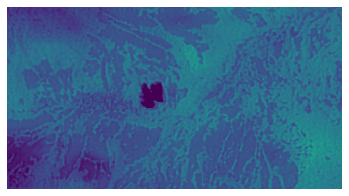

In [304]:
vmax = np.max([np.max(img_ndvi), np.max(img_ndvi_), np.max(ens_array)])
vmin = np.min([np.min(img_ndvi), np.min(img_ndvi_), np.min(ens_array)])

plt.imshow(img_ndvi, vmax=1, vmin=0)
plt.axis('off')
# plt.title('NDVI (10m) 2020/08/25')
plt.savefig(f'/Users/ryotanomura/ndvi_fine.png',bbox_inches='tight')

plt.imshow(img_ndvi_, vmax=1, vmin=0)
plt.axis('off')
# plt.title('NDVI up-sampled (250m) 2020/08/25')
plt.savefig(f'/Users/ryotanomura/ndvi_coarse.png',bbox_inches='tight')

plt.imshow(ens_array, vmax=1, vmin=0)
plt.axis('off')
# plt.title('Prediction (Proposed) 2020/08/25')
plt.savefig(f'/Users/ryotanomura/pred.png',bbox_inches='tight')

(-0.5, 99.5, 99.5, -0.5)

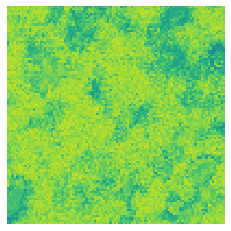

In [282]:
plt.imshow(img_reg[350:450, 600:700], vmax=vmax, vmin=vmin)
plt.axis('off')
# plt.colorbar()
# plt.title('Prediction (Proposed: Only SAR) 2020/10/05')
# plt.savefig(f'/Users/ryotanomura/pred.png',bbox_inches='tight')

# Modis - Sentinel2 

## Terra

In [51]:
# img_list = glob.glob('../sar_2_ndvi/otofuke/bin/pixel_resized/*.npy')
# imgs = np.load('/Users/ryotanomura/沖研/satellite/sar_2_ndvi/otofuke/modis/bin/all.npy')
city = 'tsumagoi'
test_idx_list = ['0127','0303','0420','0502','0818','1005','1110','1204']
# ['0328','0421','0503','0608','0620','1123'] 
# ['0127','0303','0420','0502','0818','1005','1110','1204']
# ['0325','0524','0605','0804','0828','1027','1120'] 

img_mae_list = []
img_coef_list = []

for i,idx in enumerate(test_idx_list):
    img = np.load(f'../sar_2_ndvi/{city}/bin/pixel_resized/collocate_nn_{idx}.npy')
    img_std = feature_extraction(img)

    img_ndvi_sen = drop_resolution(img_std[0], 25)[0]
#     img_ndvi_terra =  drop_resolution(img_std[-1], 25)[0]

    img_mod = np.load(f'../sar_2_ndvi/{city}/modis/bin/pixel_resized/collocate_mod_{idx}.npy')
    img_ndvi_mod = drop_resolution(img_mod[0], 25)[0]

    print(idx, '-----------------------------------')
    print('MAE', mean_absolute_error(np.ravel(img_ndvi_sen), np.ravel(img_ndvi_mod)))
    print('coef', np.corrcoef(np.ravel(img_ndvi_sen), np.ravel(img_ndvi_mod))[0][1])
    
    img_mae_list.append(mean_absolute_error(np.ravel(img_ndvi_sen), np.ravel(img_ndvi_mod)))
    img_coef_list.append(np.corrcoef(np.ravel(img_ndvi_sen), np.ravel(img_ndvi_mod))[0][1])

0328 -----------------------------------
MAE 0.03906996520434288
coef 0.7956324366443842
0421 -----------------------------------
MAE 0.058065846577538494
coef 0.7697960963605952
0503 -----------------------------------
MAE 0.08926967590728492
coef 0.8130066161250754
0608 -----------------------------------
MAE 0.09691000712431679
coef 0.8445251094432755
0620 -----------------------------------
MAE 0.11436343707204873
coef 0.7647717684971395
1123 -----------------------------------
MAE 0.08149969032050597
coef 0.7789015169503325


In [106]:
img_list = glob.glob('../sar_2_ndvi/tsumagoi/bin/pixel_resized/*.npy')
modis_img_list = glob.glob('../sar_2_ndvi/tsumagoi/modis_ensemble/bin/ensemble_ndvi/*.npy')

test_idx_list = ['0127','0303','0420','0502','0818','1005','1110','1204'] # tsumagoi
test_modis_idx_list = ['0126','0303','0425','0502','0820','1002','1108','1201'] # tsumagoi

img_mae_list = []
img_coef_list = []

for idx, mod_idx in zip(test_idx_list, test_modis_idx_list):
    img = np.load(f'../sar_2_ndvi/tsumagoi/bin/pixel_resized/collocate_nn_{idx}.npy')
    img_std = feature_extraction(img)

    img_ndvi_sen = drop_resolution(img_std[0], 25)[0]
#     img_ndvi_terra =  drop_resolution(img_std[-1], 25)[0]
    img_ndvi_mod = drop_resolution(np.load(f'../sar_2_ndvi/tsumagoi/modis_ensemble/bin/ensemble_ndvi/collocate_{mod_idx}.npy'), 25)[0]

    print(idx, '-----------------------------------')
    print('MAE', mean_absolute_error(np.ravel(img_ndvi_sen), np.ravel(img_ndvi_mod)))
    print('coef', np.corrcoef(np.ravel(img_ndvi_sen), np.ravel(img_ndvi_mod))[0][1])
    
    img_mae_list.append(mean_absolute_error(np.ravel(img_ndvi_sen), np.ravel(img_ndvi_mod)))
    img_coef_list.append(np.corrcoef(np.ravel(img_ndvi_sen), np.ravel(img_ndvi_mod))[0][1])

0127 -----------------------------------
MAE 0.0640611810091121
coef 0.6932587282500647
0303 -----------------------------------
MAE 0.049796679816526274
coef 0.6530496692822602
0420 -----------------------------------
MAE 0.05000624287958172
coef 0.7555111194287994
0502 -----------------------------------
MAE 0.05931908403819596
coef 0.7322333960158661
0818 -----------------------------------
MAE 0.08521015566181053
coef 0.690165152124288
1005 -----------------------------------
MAE 0.0685933231100948
coef 0.6338451336296739
1110 -----------------------------------
MAE 0.0594527877824889
coef 0.5138222198342433
1204 -----------------------------------
MAE 0.061764044424688275
coef 0.6887607265987544


In [448]:
test_idx_list_ = test_idx_list[:2] + ['0327'] + test_idx_list[2:]
img_mae_list_ = img_mae_list[:2] + [0] + img_mae_list[2:]
img_coef_list_ = img_coef_list[:2] + [0] + img_coef_list[2:]

Text(0, 0.5, 'Correlation coefficient')

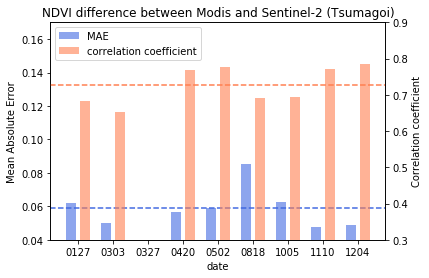

In [452]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
x_position = np.arange(len(test_idx_list_))

ln1 = ax1.bar(x_position, np.array(img_mae_list_), width=0.3, label='MAE', color='royalblue', alpha=0.6)
ax1.set_ylim(0.04, 0.17)
ax1.axhline(np.mean(img_mae_list), linestyle = 'dashed',color='royalblue')

ax2 = ax1.twinx()
ln2=ax2.bar(x_position+0.4, np.array(img_coef_list_), width=0.3, label='correlation coefficient', color='coral', alpha=0.6)
ax2.set_ylim(0.3, 0.9)
ax2.axhline(np.mean(img_coef_list), linestyle = 'dashed', color='coral')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left')

ax1.set_xticks(x_position + 0.2)
ax1.set_xticklabels(test_idx_list_)
ax1.set_title('NDVI difference between Modis and Sentinel-2 (Tsumagoi)')
ax1.set_xlabel('date')
ax1.set_ylabel('Mean Absolute Error')
ax2.set_ylabel('Correlation coefficient')

In [115]:
# 250 -> 10, different week, leave one out, Modis
city = 'tsumagoi'
# test_idx_list = ['0325','0524','0605','0804','0828','1027','1120'] # otofuke
test_idx_list = ['0127','0303','0420','0502','0818','1005','1110','1204'] # tsumagoi
# test_idx_list = ['0328','0421','0503','0608','0620','1123'] # niigata

mae_list = []
coef_list = []

channel_num = 3
model = create_srcnn(channel_num)
model.load_weights(f'../sar_2_ndvi/{city}/model_weight/srcnn_125_all_nodem_19/srcnn_4ch_nodem_all.h5')

for idx in test_idx_list:
    
    X_array = np.load(f'../sar_2_ndvi/{city}/modis/bin/patch_sr/input/X_{idx}.npy')
    y_array = np.load(f'../sar_2_ndvi/{city}/bin/patch_sr/125/test/y_{idx}.npy')

    y_pred = model.predict(X_array[:,:,:,:channel_num])
    
    print(idx, '-----------------------')
    print('MAE', mean_absolute_error(np.ravel(y_array), np.ravel(y_pred)))
    print('coef', np.corrcoef(np.ravel(y_array), np.ravel(y_pred))[0][1])
    
    mae_list.append(mean_absolute_error(np.ravel(y_array), np.ravel(y_pred)))
    coef_list.append(np.corrcoef(np.ravel(y_array), np.ravel(y_pred))[0][1])

0127 -----------------------
MAE 0.12191675
coef 0.5006967627226804
0303 -----------------------
MAE 0.10323457
coef 0.6642296821079814
0420 -----------------------
MAE 0.09965155
coef 0.6295522693118863
0502 -----------------------
MAE 0.08745215
coef 0.731613241925289
0818 -----------------------
MAE 0.15441655
coef 0.7174147616269803
1005 -----------------------
MAE 0.116357885
coef 0.6234443503728614
1110 -----------------------
MAE 0.09854831
coef 0.600568871006568
1204 -----------------------
MAE 0.09158314
coef 0.7008097283623373


In [116]:
print(np.mean(mae_list))
print(np.mean(coef_list))

0.10914511
0.646041208429573


Text(0, 0.5, 'Correlation coefficient')

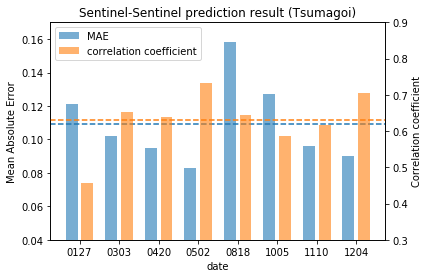

In [456]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
x_position = np.arange(len(test_idx_list))

ln1 = ax1.bar(x_position, np.array(mae_list), width=0.3, label='MAE', color='C0', alpha=0.6)
ax1.set_ylim(0.04, 0.17)
ax1.axhline(np.mean(mae_list), linestyle = 'dashed',color='C0')

ax2 = ax1.twinx()
ln2=ax2.bar(x_position+0.4, np.array(coef_list), width=0.3, label='correlation coefficient', color='C1', alpha=0.6)
ax2.set_ylim(0.3, 0.9)
ax2.axhline(np.mean(coef_list), linestyle = 'dashed', color='C1')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left')

ax1.set_xticks(x_position + 0.2)
ax1.set_xticklabels(test_idx_list)
ax1.set_title('Sentinel-Sentinel prediction result (Tsumagoi)')
ax1.set_xlabel('date')
ax1.set_ylabel('Mean Absolute Error')
ax2.set_ylabel('Correlation coefficient')

## Terra & Aqua

In [384]:
img = np.load('/Users/ryotanomura/沖研/satellite/sar_2_ndvi/otofuke/output_test/collocate_nn_0605.npy')
img_std = feature_extraction_modis(img)

img_ndvi_sen = drop_resolution(img_std[0], 25)[0]
img_ndvi_terra =  drop_resolution(img_std[-2], 25)[0]
img_ndvi_aqua =  drop_resolution(img_std[-1], 25)[0]
img_ndvi_ens =  (img_ndvi_terra + img_ndvi_aqua)/2

img_list = [img_ndvi_sen, img_ndvi_terra, img_ndvi_aqua, img_ndvi_ens]
label_list = ['sen', 'terra', 'aqua', 'ens']

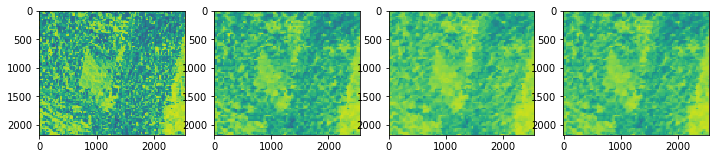

In [385]:
plt.figure(figsize=(12,4))
for i, img in enumerate(img_list):
    plt.subplot(1,4,i+1)
    plt.imshow(img, vmin=-0.2, vmax=1)

MAE 0.10775614404580282
coef 0.7423563940379383


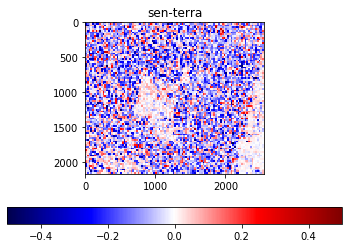

MAE 0.13629838107592462
coef 0.7324879035991093


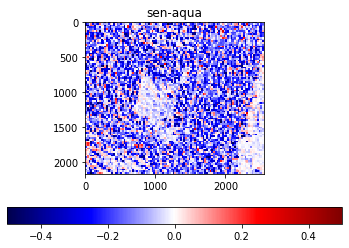

MAE 0.11785722524851244
coef 0.7616649569383429


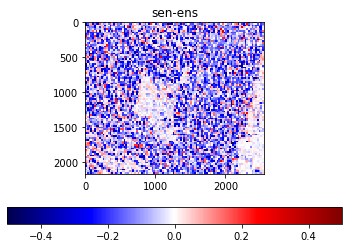

In [389]:
for i, img in enumerate(img_list[1:]):
    print('MAE', mean_absolute_error(img_ndvi_sen, img))
    print('coef', np.corrcoef(np.ravel(img_ndvi_sen), np.ravel(img))[0][1])
    plt.title('sen' + '-' + label_list[i+1])
    plt.imshow(img_ndvi_sen - img, vmin=-0.5, vmax=0.5, cmap='seismic')
    plt.colorbar(orientation='horizontal')
    plt.show()

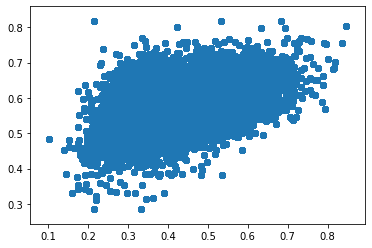

In [252]:
plt.scatter(np.ravel(img_ndvi_sen), np.ravel(img_ndvi_mod))

In [241]:
# 250 -> 10, different week, leave one out, Modis
city = 'otofuke'
test_idx_list = ['0325','0524','0605','0804','0828','1027','1120'] # otofuke
# test_idx_list = ['0127','0303','0327','0420','0502','0818','1005','1110','1204'] # tsumagoi

for idx in test_idx_list:

    model_name = f'srcnn_4ch_{idx}.h5'
    channel_num = 4

    model = create_srcnn(channel_num)
    model.load_weights(f'../sar_2_ndvi/{city}/model_weight/srcnn_125_loc/{model_name}')
    
    X_array = np.load(f'/Users/ryotanomura/沖研/satellite/sar_2_ndvi/{city}/bin/patch_sr/125/test_modis/X_{idx}.npy')
    y_array = np.load(f'/Users/ryotanomura/沖研/satellite/sar_2_ndvi/{city}/bin/patch_sr/125/test_modis//y_{idx}.npy')

    y_pred = model.predict(X_array[:,:,:,:channel_num])
    
    print(idx, '-----------------------')
    print('MAE', mean_absolute_error(np.ravel(y_array), np.ravel(y_pred)))
    print('coef', np.corrcoef(np.ravel(y_array), np.ravel(y_pred))[0][1])
    print('PSNR', cal_psnr(y_array, y_pred))

0325 -----------------------
MAE 0.084065974
coef 0.27875522798450736
PSNR 67.35215576740562
0524 -----------------------
MAE 0.24220267
coef 0.2867140822930872
PSNR 59.1844236654522
0605 -----------------------
MAE 0.17004743
coef 0.6867411133087581
PSNR 61.68079930242462
0804 -----------------------
MAE 0.12967896
coef 0.6282647770324401
PSNR 62.30728111666967
0828 -----------------------
MAE 0.13886715
coef 0.6907502614440272
PSNR 62.289129111554665
1027 -----------------------
MAE 0.16597068
coef 0.45980289841926736
PSNR 61.86123844218283
1120 -----------------------
MAE 0.22566754
coef 0.08361198302932622
PSNR 59.750018558888236


# Other methods for comparison

## BIliner interpolation

In [458]:
# Data setting
img_list = glob.glob('../sar_2_ndvi/otofuke/bin/pixel_resized/*.npy')

for path in img_list:
    img = np.load(path)
    c, h, w = img.shape
    h = (h//scale)*scale
    w = (w//scale)*scale

    img = img[:, :h, :w]
    img_std = feature_extraction(img)
    img_ndvi = img_std[0]
    img_ndvi_coarse, img_ndvi_small = drop_resolution(img_ndvi, 25)
    
    img_ndvi_bilinear = cv2.resize(img_ndvi_small, (w, h), interpolation=cv2.INTER_LINEAR)
    print(path)
    print(mean_absolute_error(np.ravel(img_ndvi_bilinear), np.ravel(img_ndvi)))
    print(np.corrcoef(np.ravel(img_ndvi_bilinear), np.ravel(img_ndvi))[0][1])

../sar_2_ndvi/otofuke/bin/pixel_resized/collocate_nn_1027.npy
0.1285356733915903
0.6494475130279239
../sar_2_ndvi/otofuke/bin/pixel_resized/collocate_nn_cloud_1015.npy
0.14314993778733162
0.6987637218316192
../sar_2_ndvi/otofuke/bin/pixel_resized/collocate_nn_1120.npy
0.10798238621079465
0.6360650740648215
../sar_2_ndvi/otofuke/bin/pixel_resized/collocate_nn_0605.npy
0.17532160076331116
0.6941130609219291
../sar_2_ndvi/otofuke/bin/pixel_resized/collocate_nn_cloud_0816.npy
0.1462721489949364
0.6510756612863806
../sar_2_ndvi/otofuke/bin/pixel_resized/collocate_nn_0828.npy
0.15474507506228052
0.6671236355508875
../sar_2_ndvi/otofuke/bin/pixel_resized/collocate_nn_cloud_1108.npy
0.11051744302821183
0.6636007393144148
../sar_2_ndvi/otofuke/bin/pixel_resized/collocate_nn_0804.npy
0.1364500566676158
0.6568445027111551
../sar_2_ndvi/otofuke/bin/pixel_resized/collocate_nn_0524.npy
0.15893141788871484
0.6790106848674501
../sar_2_ndvi/otofuke/bin/pixel_resized/collocate_nn_0325.npy
0.065533007324

## Linear Regression

In [121]:
# Data Setting
city = 'tsumagoi'
img_list = glob.glob(f'../sar_2_ndvi/{city}/modis/bin_19/pixel_resized/*.npy')
scale = 25

for path in img_list:
    idx = path[-8:-4]
    img = np.load(path)
    c, h, w = img.shape
    h = (h//scale)*scale
    w = (w//scale)*scale
    
    print(path, h, w)

    img = img[:, :h, :w]
    img_std = feature_extraction(img)
    img_ndvi = img_std[0]
    img_ndvi_coarse, img_ndvi_small = drop_resolution(img_ndvi, 25)
    img_ndvi_coarse = cv2.resize(img_ndvi_small, (w, h), interpolation=cv2.INTER_LINEAR)
    
    y = np.ravel(img_ndvi)
    X = np.array([np.ravel(img_ndvi_coarse), np.ravel(img_std[1]), np.ravel(img_std[2]), np.ravel(img_std[3])]).transpose(1,0)

    np.save(f'../sar_2_ndvi/{city}/bin/patch_sr/125/train_linear/X_{idx}.npy', X)
    np.save(f'../sar_2_ndvi/{city}/bin/patch_sr/125/train_linear/y_{idx}.npy', y)

In [159]:
city = 'tsumagoi'

idx_list = ['0127','0303','0420','0502','0818','1005','1110','1204'] # tsumagoi
# idx_list = ['0325','0524','0605','0804','0828','1027','1120'] # otofuke
# idx_list = ['0328','0421','0503','0608','0620','0924','1123'] # niigata

mae_reg_list = []
coef_reg_list = []

for idx in idx_list:
    x_paths = glob.glob(f'../sar_2_ndvi/{city}/bin/patch_sr/125/val_linear/X_*.npy')
    x_paths = list(filter(lambda x: idx not in x, x_paths))
    y_paths = glob.glob(f'../sar_2_ndvi/{city}/bin/patch_sr/125/val_linear/y_*.npy')
    y_paths = list(filter(lambda x: idx not in x, y_paths))
    
    for i, (x_path, y_path) in enumerate(zip(x_paths, y_paths)):
        if i == 0:
            X = np.load(x_path)
            y = np.load(y_path)
        else:
            X = np.concatenate([X, np.load(x_path)])
            y = np.concatenate([y, np.load(y_path)])
            
    X_test = np.load(f'../sar_2_ndvi/{city}/bin/patch_sr/125/val_linear/X_{idx}.npy')
    y_test = np.load(f'../sar_2_ndvi/{city}/bin/patch_sr/125/val_linear/y_{idx}.npy')
    
    model = linear_model.LinearRegression()
    model.fit(X, y)
    
    y_pred = model.predict(X_test)
    
    print(idx, '------------------------------------------')
    print('MAE: ', mean_absolute_error(y_pred, y_test))
    print('coef: ', np.corrcoef(y_pred, y_test)[0][1])
    print('Importance: ', model.coef_)
    
    mae_reg_list.append(mean_absolute_error(y_pred, y_test))
    coef_reg_list.append(np.corrcoef(y_pred, y_test)[0][1])

In [177]:
# with 2019 model
city = 'tsumagoi'

idx_list = ['0127','0303','0420','0502','0818','1005','1110','1204'] # tsumagoi
# idx_list = ['0325','0524','0605','0804','0828','1027','1120'] # otofuke
# idx_list = ['0328','0421','0503','0608','0620','0924','1123'] # niigata
# idx_list = ['0310','0621','0825','0906'] # oushu

mae_reg_list = []
coef_reg_list = []

x_paths = glob.glob(f'../sar_2_ndvi/{city}/bin_19/patch_sr/125/val_linear/X_*.npy')
y_paths = glob.glob(f'../sar_2_ndvi/{city}/bin_19/patch_sr/125/val_linear/y_*.npy')

for i, (x_path, y_path) in enumerate(zip(x_paths, y_paths)):
    if i == 0:
        X = np.load(x_path)[:,:3]
        y = np.load(y_path)
    else:
        X = np.concatenate([X, np.load(x_path)[:,:3]])
        y = np.concatenate([y, np.load(y_path)])
        
model = linear_model.LinearRegression()
model.fit(X, y)

for idx in idx_list:
            
    X_test = np.load(f'../sar_2_ndvi/{city}/bin/patch_sr/125/val_linear_mod/X_{idx}.npy')[:,:3]
    y_test = np.load(f'../sar_2_ndvi/{city}/bin/patch_sr/125/val_linear_mod/y_{idx}.npy')
    
    y_pred = model.predict(X_test)
    
    print(idx, '------------------------------------------')
    print('MAE: ', mean_absolute_error(y_pred, y_test))
    print('coef: ', np.corrcoef(y_pred, y_test)[0][1])
    print('Importance: ', model.coef_)
    
    mae_reg_list.append(mean_absolute_error(y_pred, y_test))
    coef_reg_list.append(np.corrcoef(y_pred, y_test)[0][1])

0127 ------------------------------------------
MAE:  0.12163305704289444
coef:  0.44607516876303294
Importance:  [ 0.98278386  0.44307812 -0.24607657]
0303 ------------------------------------------
MAE:  0.11091412624982995
coef:  0.44370311758628905
Importance:  [ 0.98278386  0.44307812 -0.24607657]
0420 ------------------------------------------
MAE:  0.09571326273842787
coef:  0.603857624749713
Importance:  [ 0.98278386  0.44307812 -0.24607657]
0502 ------------------------------------------
MAE:  0.09426358747935393
coef:  0.6558186064717764
Importance:  [ 0.98278386  0.44307812 -0.24607657]
0818 ------------------------------------------
MAE:  0.16398706437486651
coef:  0.5304662711635626
Importance:  [ 0.98278386  0.44307812 -0.24607657]
1005 ------------------------------------------
MAE:  0.13454970374996097
coef:  0.5129000104111648
Importance:  [ 0.98278386  0.44307812 -0.24607657]
1110 ------------------------------------------
MAE:  0.10035146287207393
coef:  0.5455014630

## Random Forest

In [317]:
# with 2019 model
city = 'tsumagoi'

idx_list = ['0127','0303','0420','0502','0818','1005','1110','1204'] # tsumagoi
# idx_list = ['0325','0524','0605','0804','0828','1027','1120'] # otofuke
# idx_list = ['0328','0421','0503','0608','0620','0924','1123'] # niigata
# idx_list = ['0310','0621','0825','0906'] # oushu

mae_reg_list = []
coef_reg_list = []

x_paths = glob.glob(f'../sar_2_ndvi/{city}/bin_19/patch_sr/125/val_linear/X_*.npy')
y_paths = glob.glob(f'../sar_2_ndvi/{city}/bin_19/patch_sr/125/val_linear/y_*.npy')

for i, (x_path, y_path) in enumerate(zip(x_paths, y_paths)):
    if i == 0:
        X = np.load(x_path)[:,:3]
        y = np.load(y_path)
    else:
        X = np.concatenate([X, np.load(x_path)[:,:3]])
        y = np.concatenate([y, np.load(y_path)])
        
model = RFR()
model.fit(X, y)

for idx in idx_list:
            
    X_test = np.load(f'../sar_2_ndvi/{city}/bin/patch_sr/125/val_linear_mod/X_{idx}.npy')[:,:3]
    y_test = np.load(f'../sar_2_ndvi/{city}/bin/patch_sr/125/val_linear_mod/y_{idx}.npy')
    
    y_pred = model.predict(X_test)
    
    print(idx, '------------------------------------------')
    print('MAE: ', mean_absolute_error(y_pred, y_test))
    print('coef: ', np.corrcoef(y_pred, y_test)[0][1])
#     print('Importance: ', model.coef_)
    
    mae_reg_list.append(mean_absolute_error(y_pred, y_test))
    coef_reg_list.append(np.corrcoef(y_pred, y_test)[0][1])

0127 ------------------------------------------
MAE:  0.1263454976736095
coef:  0.4248347512828318
0303 ------------------------------------------
MAE:  0.11319671333276697
coef:  0.5220902008849241
0420 ------------------------------------------
MAE:  0.10063580358021144
coef:  0.544414393996516
0502 ------------------------------------------
MAE:  0.09298022883724527
coef:  0.6440186677267891
0818 ------------------------------------------
MAE:  0.15402158861312948
coef:  0.4996136011987444
1005 ------------------------------------------
MAE:  0.12969520028387657
coef:  0.4494108247764645
1110 ------------------------------------------
MAE:  0.10476791222683411
coef:  0.48422989979817105
1204 ------------------------------------------
MAE:  0.10106637765765311
coef:  0.6030619110421189


In [318]:
print(np.mean(mae_reg_list))
print(np.std(mae_reg_list))
print(np.mean(coef_reg_list))

0.1153386652756658
0.0189067772531882
0.52145928133832


## Visualization

Text(0, 0.5, 'Correlation coefficient')

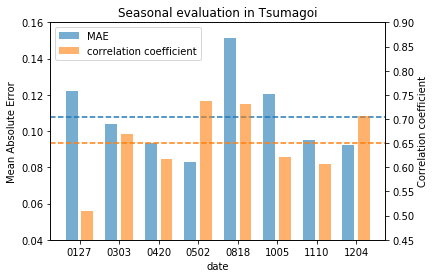

In [31]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
x_position = np.arange(len(test_idx_list))

ln1 = ax1.bar(x_position, np.array(mae_list), width=0.3, label='MAE', color='C0', alpha=0.6)
ax1.set_ylim(0.04, 0.16)
ax1.axhline(np.mean(mae_list), linestyle = 'dashed',color='C0')

ax2 = ax1.twinx()
ln2=ax2.bar(x_position+0.4, np.array(coef_list), width=0.3, label='correlation coefficient', color='C1', alpha=0.6)
ax2.set_ylim(0.45, 0.9)
ax2.axhline(np.mean(coef_list), linestyle = 'dashed', color='C1')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left')

ax1.set_xticks(x_position + 0.2)
ax1.set_xticklabels(test_idx_list)
ax1.set_title('Seasonal evaluation in Tsumagoi')
ax1.set_xlabel('date')
ax1.set_ylabel('Mean Absolute Error')
ax2.set_ylabel('Correlation coefficient')

# Training scheme analysis

## Difference between 2 schemes

In [185]:
city = 'otofuke'

idx_list = ['0325','0524','0605','0804','0828','1027','1120']
idx_list_sub = ['0524', '0605', '0524', '0828', '0804', '1120', '1027']

mae_list = [[], []]
coef_list = [[], []]

for idx, idx_sub in zip(idx_list, idx_list_sub):

    X_test = np.load(f'../sar_2_ndvi/otofuke/bin/patch_sr/125/test/X_{idx}.npy')
    y_test = np.load(f'../sar_2_ndvi/otofuke/bin/patch_sr/125/test/y_{idx}.npy')

    model_single = create_srcnn(channel_num)
    model_single.load_weights(f'../sar_2_ndvi/{city}/model_weight/srcnn_125_single/srcnn_4ch_{idx_sub}.h5')

    model_multiple = create_srcnn(channel_num)
    model_multiple.load_weights(f'../sar_2_ndvi/{city}/model_weight/srcnn_125_loc/srcnn_4ch_{idx}.h5')

    y_pred_single = model_single.predict(X_test)
    y_pred_multiple = model_multiple.predict(X_test)

    print('single-----------------------')
    print('MAE: ', mean_absolute_error(np.ravel(y_pred_single), np.ravel(y_test)))
    print('coef: ', np.corrcoef(np.ravel(y_pred_single), np.ravel(y_test))[0][1])
    mae_list[0].append(mean_absolute_error(np.ravel(y_pred_single), np.ravel(y_test)))
    coef_list[0].append(np.corrcoef(np.ravel(y_pred_single), np.ravel(y_test))[0][1])

    print('multiple-----------------------')
    print('MAE: ', mean_absolute_error(np.ravel(y_pred_multiple), np.ravel(y_test)))
    print('coef: ', np.corrcoef(np.ravel(y_pred_multiple), np.ravel(y_test))[0][1])
    mae_list[1].append(mean_absolute_error(np.ravel(y_pred_multiple), np.ravel(y_test)))
    coef_list[1].append(np.corrcoef(np.ravel(y_pred_multiple), np.ravel(y_test))[0][1])

single-----------------------
MAE:  0.09040048
coef:  0.11695528396225334
multiple-----------------------
MAE:  0.071837164
coef:  0.4865299072247169
single-----------------------
MAE:  0.25316906
coef:  0.41239606821970975
multiple-----------------------
MAE:  0.1070787
coef:  0.8202381535936766
single-----------------------
MAE:  0.35271534
coef:  0.4781219355332067
multiple-----------------------
MAE:  0.12710613
coef:  0.7979182860381449
single-----------------------
MAE:  0.43871817
coef:  0.24134056500884318
multiple-----------------------
MAE:  0.102733456
coef:  0.7514181734815758
single-----------------------
MAE:  0.3059776
coef:  0.6435830298047832
multiple-----------------------
MAE:  0.11188362
coef:  0.7854122080363671
single-----------------------
MAE:  0.25619575
coef:  0.2069006076675253
multiple-----------------------
MAE:  0.12316732
coef:  0.6694456329102986
single-----------------------
MAE:  0.17413108
coef:  0.2226138102785889
multiple-----------------------
MAE:

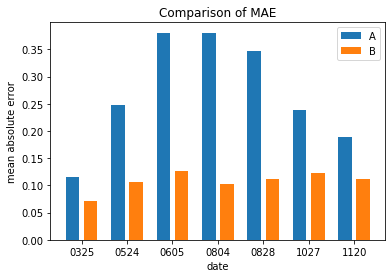

In [538]:
x_position = np.arange(len(idx_list))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(x_position, np.array(mae_list[0]), width=0.3, label='A')
ax.bar(x_position+0.4, np.array(mae_list[1]), width=0.3, label='B')
ax.legend()
ax.set_xticks(x_position + 0.2)
ax.set_xticklabels(idx_list)
ax.set_title('Comparison of MAE')
ax.set_xlabel('date')
ax.set_ylabel('mean absolute error')
plt.show()

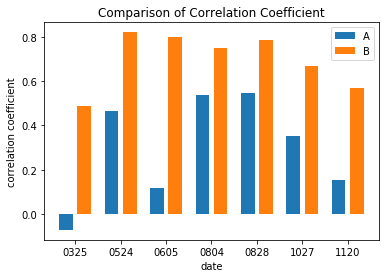

In [541]:
x_position = np.arange(len(idx_list))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(x_position, np.array(coef_list[0]), width=0.3, label='A')
ax.bar(x_position+0.4, np.array(coef_list[1]), width=0.3, label='B')
ax.legend()
ax.set_xticks(x_position + 0.2)
ax.set_xticklabels(idx_list)
ax.set_title('Comparison of Correlation Coefficient')
ax.set_xlabel('date')
ax.set_ylabel('correlation coefficient')
plt.show()

## Sensitivity analysis

In [133]:
def generate_random_input(patch, flag, v_min=-1, v_max=1, size=125, scale=5):
    if flag == 'NDVI':
        random_img = (v_max-v_min)*np.random.rand(scale, scale) + v_min
        random_img_resized = random_img.repeat(size//scale, axis=0).repeat(size//scale, axis=1)
        new_patch = np.concatenate([random_img_resized.reshape((size, size, 1)), patch[:,:,1:]], axis=2)
    elif flag == 'SAR':
        random_vh = (v_max-v_min)*np.random.rand(size, size) + v_min
        random_vv = (v_max-v_min)*np.random.rand(size, size) + v_min
        new_patch = np.array([patch[:,:,0], random_vh, random_vv, patch[:,:,3]]).transpose(1,2,0)
    return new_patch

def add_noise_2_sar(patch, mean=0, std=0.1):
    vh = patch[:,:,1]
    vv = patch[:,:,2]
    vh_noisy = vh + np.random.normal(mean, std, vh.shape)
    vv_noisy = vv + np.random.normal(mean, std, vv.shape)
    vh_noisy = np.clip(vh_noisy, -1, 1)
    vv_noisy = np.clip(vv_noisy, -1, 1)
    return np.array([patch[:,:,0], vh_noisy, vv_noisy, patch[:,:,3]]).transpose(1,2,0)

In [116]:
idx_list = ['0325','0524','0605','0804','0828','1027','1120']
patch_num = 1
iter_num = 3
city = 'otofuke'
flag = 'SAR'

single_pred_list = []
single_psuedo_pred_list = []
multiple_pred_list = []
multiple_psuedo_pred_list = []

for idx in idx_list:
    X_test = np.load(f'../sar_2_ndvi/{city}/bin/patch_sr/125/test/X_{idx}.npy')
    y_test = np.load(f'../sar_2_ndvi/{city}/bin/patch_sr/125/test/y_{idx}.npy')
    
    model_single = create_srcnn(channel_num)
    model_single.load_weights(f'../sar_2_ndvi/{city}/model_weight/srcnn_125_single/srcnn_4ch_{idx}.h5')

    model_multiple = create_srcnn(channel_num)
    model_multiple.load_weights(f'../sar_2_ndvi/{city}/model_weight/srcnn_125_loc/srcnn_4ch_{idx}.h5')
    
    num, h, w, c = X_test.shape
    extract_idx_list = np.random.randint(0, num, patch_num)
    
    X_patch_array = []
#     y_patch_array = []
    X_psuedo_patch_array = []
    for patch_idx in extract_idx_list:
        for i in range(iter_num):
            X_patch_array.append(X_test[patch_idx])
#             y_patch_array.append(y_test[patch_idx])
            X_psuedo_patch_array.append(generate_random_input(X_test[patch_idx], flag=flag))
    
    X_patch_array = np.array(X_patch_array)
    X_psuedo_patch_array = np.array(X_psuedo_patch_array)
    
    y_pred_single = model_single.predict(X_patch_array)
    y_psuedo_pred_single = model_single.predict(X_psuedo_patch_array)
    single_pred_list.append(np.ravel(y_pred_single).tolist())
    single_psuedo_pred_list.append(np.ravel(y_psuedo_pred_single).tolist())
    
    
    y_pred_multiple = model_multiple.predict(X_patch_array)
    y_psuedo_pred_multiple = model_multiple.predict(X_psuedo_patch_array)
    multiple_pred_list.append(np.ravel(y_pred_multiple).tolist())
    multiple_psuedo_pred_list.append(np.ravel(y_psuedo_pred_multiple).tolist())

In [98]:
single_pred_list = np.where(np.array(single_pred_list)>1, 1, np.array(single_pred_list))
single_pred_list = np.where(np.array(single_pred_list)<-1, -1, np.array(single_pred_list))

single_psuedo_pred_list = np.where(np.array(single_psuedo_pred_list)>1, 1, np.array(single_psuedo_pred_list))
single_psuedo_pred_list = np.where(np.array(single_psuedo_pred_list)<-1, -1, np.array(single_psuedo_pred_list))

multiple_pred_list = np.where(np.array(multiple_pred_list)>1, 1, np.array(multiple_pred_list))
multiple_pred_list = np.where(np.array(multiple_pred_list)<-1, -1, np.array(multiple_pred_list))

multiple_psuedo_pred_list = np.where(np.array(multiple_psuedo_pred_list)>1, 1, np.array(multiple_psuedo_pred_list))
multiple_psuedo_pred_list = np.where(np.array(multiple_psuedo_pred_list)<-1, -1, np.array(multiple_psuedo_pred_list))

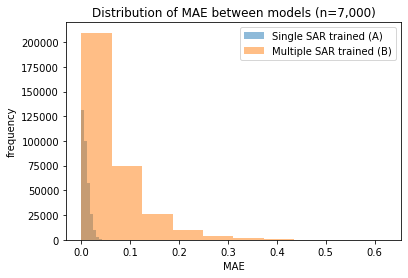

In [135]:
plt.hist(np.ravel(np.abs(np.array(single_pred_list) - np.array(single_psuedo_pred_list))), alpha=0.5, label='Single SAR trained (A)')
plt.hist(np.ravel(np.abs(np.array(multiple_pred_list) - np.array(multiple_psuedo_pred_list))), alpha=0.5,  label='Multiple SAR trained (B)')
# plt.hist(np.ravel(np.abs(np.array(single_pred_list) - np.array(single_psuedo_pred_list))), alpha=0.5, label='Single SAR trained (A)')
# plt.hist(np.ravel(np.abs(np.array(multiple_pred_list) - np.array(multiple_psuedo_pred_list))), alpha=0.5,  label='Multiple SAR trained (B)')
plt.title('Distribution of MAE between models (n=7,000)')
plt.xlabel('MAE')
plt.ylabel('frequency')
plt.legend()

## Modis Terra-Aqua ensembling 

In [290]:
# Save with NDVI
bin_path_list = glob.glob('/Users/ryotanomura/沖研/satellite/sar_2_ndvi/tsumagoi/modis_test/bin/raw/*.npy')
extract_dict = {'0126': 'ens', '0303': 'aqua', '0326': 'none', '0425': 'ens', '0502': 'ens', '0820': 'terra', '1002': 'ens', '1108': 'terra', '1201': 'terra'}

for idx, dtype in extract_dict.items():
    extract_list = list(filter(lambda x: '_'+idx+'.' in x, bin_path_list))
    assert len(extract_list) == 1
    
    path = extract_list[0]
    save_path = path.replace('raw', 'ensemble_r_ir')
    
    img = np.load(path)
    if dtype == 'ens':
        ndvi_terra = cal_ndvi(img[0], img[1])
        ndvi_aqua = cal_ndvi(img[2], img[3])
        img_result = np.mean([ndvi_terra, ndvi_aqua], axis=0)
    elif dtype == 'terra':
        img_result = cal_ndvi(img[0], img[1])
    elif dtype == 'aqua':
        img_result = cal_ndvi(img[2], img[3])
    else:
        continue
    
#     img_result = drop_resolution(img_result, 25)[0]
    np.save(save_path, img_result)

In [14]:
# Save with R and IR
bin_path_list = glob.glob('/Users/ryotanomura/沖研/satellite/sar_2_ndvi/tsumagoi/modis_ensemble/bin/raw/*.npy')
extract_dict = {'0126': 'ens', '0303': 'aqua', '0326': 'none', '0425': 'ens', '0502': 'ens', '0820': 'terra', '1002': 'ens', '1108': 'terra', '1201': 'terra'}

for idx, dtype in extract_dict.items():
    extract_list = list(filter(lambda x: '_'+idx+'.' in x, bin_path_list))
    assert len(extract_list) == 1
    
    path = extract_list[0]
    save_path = path.replace('raw', 'ensemble_r_ir')
    
    img = np.load(path)
    if dtype == 'ens':
        R = np.mean(np.array([img[0], img[2]]), axis=0)
        IR = np.mean(np.array([img[1], img[3]]), axis=0)
        img_result = np.array([R, IR])
    elif dtype == 'terra':
        img_result = np.array([img[0], img[1]])
    elif dtype == 'aqua':
        img_result = np.array([img[2], img[3]])
    else:
        continue
    
#     img_result = drop_resolution(img_result, 25)[0]
    np.save(save_path, img_result)

# Model accuracy analysis by data number

In [331]:
# 250 -> 10, different week, leave one out, Modis
city = 'otofuke'
test_idx_list = ['0325','0524','0605'] # otofuke
# test_idx_list = ['0325','0524','0605','0804','0828','1027','1120'] # otofuke
# test_idx_list = ['0127','0303','0420','0502','0818','1005','1110','1204'] # tsumagoi

mae_list = []
coef_list = []

for idx in test_idx_list:
    
    mae_list_sub = []
    coef_list_sub = []
    
    for i in range(1, 7):

        model_name = f'srcnn_4ch_{idx}-{i}.h5'
        channel_num = 4

        model = create_srcnn(channel_num)
        model.load_weights(f'../sar_2_ndvi/{city}/model_weight/srcnn_125_data_num/{model_name}')

        X_array = np.load(f'/Users/ryotanomura/沖研/satellite/sar_2_ndvi/{city}/bin/patch_sr/125/test/X_{idx}.npy')
        y_array = np.load(f'/Users/ryotanomura/沖研/satellite/sar_2_ndvi/{city}/bin/patch_sr/125/test//y_{idx}.npy')

        y_pred = model.predict(X_array[:,:,:,:channel_num])

        print(idx, '-----------------------')
        print(i, '%%%%%%%%%%%%%%')
        print('MAE', mean_absolute_error(np.ravel(y_array), np.ravel(y_pred)))
        print('coef', np.corrcoef(np.ravel(y_array), np.ravel(y_pred))[0][1])

        mae_list_sub.append(mean_absolute_error(np.ravel(y_array), np.ravel(y_pred)))
        coef_list_sub.append(np.corrcoef(np.ravel(y_array), np.ravel(y_pred))[0][1])
        
    mae_list.append(mae_list_sub)
    coef_list.append(coef_list_sub)

0325 -----------------------
1 %%%%%%%%%%%%%%
MAE 0.09275751
coef 0.27257916919876674
0325 -----------------------
2 %%%%%%%%%%%%%%
MAE 0.09058895
coef 0.2979066613057085
0325 -----------------------
3 %%%%%%%%%%%%%%
MAE 0.09801965
coef 0.26802501115098665
0325 -----------------------
4 %%%%%%%%%%%%%%
MAE 0.1025429
coef 0.25845281352479316
0325 -----------------------
5 %%%%%%%%%%%%%%
MAE 0.08639394
coef 0.3569027001990475
0325 -----------------------
6 %%%%%%%%%%%%%%
MAE 0.06955382
coef 0.49060397534424277
0524 -----------------------
1 %%%%%%%%%%%%%%
MAE 0.106903225
coef 0.822622030376241
0524 -----------------------
2 %%%%%%%%%%%%%%
MAE 0.11050581
coef 0.822840346501425
0524 -----------------------
3 %%%%%%%%%%%%%%
MAE 0.11116849
coef 0.8226994463254907
0524 -----------------------
4 %%%%%%%%%%%%%%
MAE 0.100264624
coef 0.8388205585287147
0524 -----------------------
5 %%%%%%%%%%%%%%
MAE 0.1044596
coef 0.8299059625971628
0524 -----------------------
6 %%%%%%%%%%%%%%
MAE 0.10844286
co

# Model accuracy by DEM

In [568]:
# 250 -> 10, different week, leave one out, Modis
city = 'niigata'
# test_idx_list = ['0325','0524','0605','0804','0828','1027','1120'] # otofuke
# test_idx_list = ['0127','0303','0420','0502','0818','1005','1110','1204'] # tsumagoi
test_idx_list = ['0328','0421','0503','0608','0620','0924','1123'] # niigata

mae_list = []
coef_list = []

for idx in test_idx_list:
    
    model_name = f'srcnn_4ch_nodem_{idx}.h5'
    channel_num = 3

    model = create_srcnn(channel_num)
    model.load_weights(f'../sar_2_ndvi/{city}/model_weight/srcnn_125_loc_nodem/{model_name}')

    X_array = np.load(f'/Users/ryotanomura/沖研/satellite/sar_2_ndvi/{city}/bin/patch_sr/125/test/X_{idx}.npy')
    y_array = np.load(f'/Users/ryotanomura/沖研/satellite/sar_2_ndvi/{city}/bin/patch_sr/125/test//y_{idx}.npy')

    y_pred = model.predict(X_array[:,:,:,:channel_num])

    print(idx, '-----------------------')
    print('MAE', mean_absolute_error(np.ravel(y_array), np.ravel(y_pred)))
    print('coef', np.corrcoef(np.ravel(y_array), np.ravel(y_pred))[0][1])

    mae_list.append(mean_absolute_error(np.ravel(y_array), np.ravel(y_pred)))
    coef_list.append(np.corrcoef(np.ravel(y_array), np.ravel(y_pred))[0][1])

0328 -----------------------
30 %%%%%%%%%%%%%%
MAE 0.05269689
coef 0.6148260769373116
0421 -----------------------
30 %%%%%%%%%%%%%%
MAE 0.08620839
coef 0.5951017045879906
0503 -----------------------
30 %%%%%%%%%%%%%%
MAE 0.075790286
coef 0.6733305353511906
0608 -----------------------
30 %%%%%%%%%%%%%%
MAE 0.08899472
coef 0.646442610307744
0620 -----------------------
30 %%%%%%%%%%%%%%
MAE 0.13310981
coef 0.627842469084705
0924 -----------------------
30 %%%%%%%%%%%%%%
MAE 0.11931513
coef 0.5698602893807418
1123 -----------------------
30 %%%%%%%%%%%%%%
MAE 0.08092493
coef 0.56484712600328


In [569]:
print(np.mean(mae_list))
print(np.mean(coef_list))

0.091005735
0.6131786873789948


# Visualization for presentation

In [358]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + datetime.timedelta(n)

start_date = datetime.date(2020,12,1)
end_date = datetime.date(2020,12,31)

date_str_list = []
for dt in daterange(start_date, end_date):
    date_str_list.append(dt.strftime("%m-%d"))

In [359]:
s1_list = []
s2_list = []
for i, date_str in enumerate(date_str_list):
    if i % 12 in [1,6]:
        s1_list.append(1)
    else:
        s1_list.append(0)
    if i % 10 in [4,7]:
        s2_list.append(1)
    else:
        s2_list.append(0)

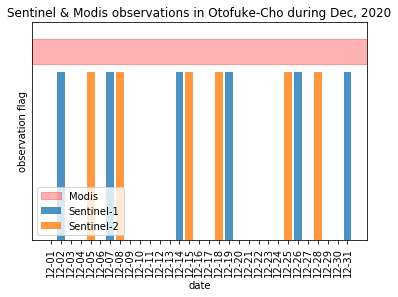

In [387]:
fig, ax = plt.subplots()

ax.bar(date_str_list, s1_list, label='Sentinel-1', alpha=0.8)
ax.bar(date_str_list, s2_list, label='Sentinel-2', alpha=0.8)

ax.axhspan(ymin=1.05, ymax=1.2, xmin=0, xmax=1, color='red', alpha=0.3, label='Modis')

ax.set_title('Sentinel & Modis observations in Otofuke-Cho during Dec, 2020')
ax.set_xlabel('date')
ax.set_ylabel('observation flag')
ticks = plt.xticks(rotation=90)
plt.ylim(0,1.3)
ax = plt.gca()
ax.axes.yaxis.set_ticks([])

plt.legend()

# Validation for epoch number

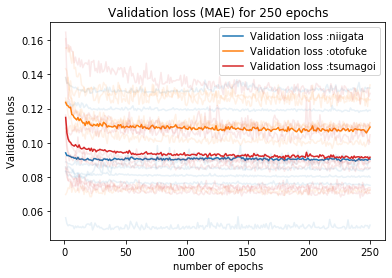

In [557]:
# tsumagoi, niigata, otofuke
loc_list = ['niigata', 'otofuke', 'tsumagoi']
color_list = ['C0', 'C1', 'C3']
num_epoch = 250
x_list = list(range(1,num_epoch+1))

for loc, color in zip(loc_list, color_list):
#     loss_sum_list = []
    val_loss_sum_list = []
    
    history_dir = f'/Users/ryotanomura/沖研/satellite/sar_2_ndvi/{loc}/model_weight/srcnn_125_loc/history/'
    history_path = glob.glob(history_dir + '*.pickle')
    
    for path in history_path:
        with open(path, 'rb') as f:
            history = pickle.load(f)
        
#         loss_list = history.history['loss']
        val_loss_list = history.history['val_loss']
        
        loss_sum_list.append(loss_list)
        val_loss_sum_list.append(val_loss_list)

#         plt.plot(x_list, loss_list, alpha=0.1, color=color)
        plt.plot(x_list, val_loss_list, alpha=0.1, color=color)
    
    val_loss_sum_list = np.array(val_loss_sum_list)
    plt.plot(x_list, np.mean(val_loss_sum_list, axis=0), alpha=1, color=color, label=f'Validation loss :{loc}')
    
plt.xlabel('number of epochs')
plt.ylabel('Validation loss')
plt.title('Validation loss (MAE) for 250 epochs')
plt.legend()

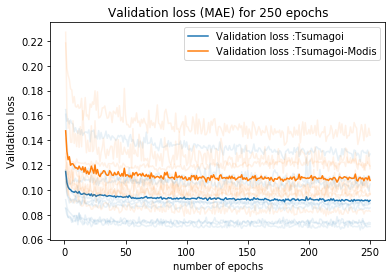

In [560]:
# Modis
color_list = ['C0', 'C1']
label_list = ['Tsumagoi', 'Tsumagoi-Modis']
num_epoch = 250
x_list = list(range(1,num_epoch+1))
history_list = ['../sar_2_ndvi/tsumagoi/model_weight/srcnn_125_loc/history/', '../sar_2_ndvi/tsumagoi/model_weight/srcnn_125_loc_modis/history/']

for history_dir, color, label in zip(history_list, color_list, label_list):
    history_path = glob.glob(history_dir + '*.pickle')
    val_loss_sum_list = []

    for path in history_path:
        with open(path, 'rb') as f:
            history = pickle.load(f)

        val_loss_list = history.history['val_loss']
        val_loss_sum_list.append(val_loss_list)

        plt.plot(x_list, val_loss_list, alpha=0.1, color=color)

    val_loss_sum_list = np.array(val_loss_sum_list)
    plt.plot(x_list, np.mean(val_loss_sum_list, axis=0), alpha=1, color=color, label=f'Validation loss :{label}')

plt.xlabel('number of epochs')
plt.ylabel('Validation loss')
plt.title('Validation loss (MAE) for 250 epochs')
plt.legend()

# Past data evaluation

In [90]:
# 250 -> 10, different week, leave one out
city = 'tsumagoi'
# test_idx_list = ['0325','0524','0605','0804','0828','1027','1120'] # otofuke
# test_idx_list = ['0127','0303','0327','0420','0502','0818','1005','1110','1204'] # tsumagoi
# test_idx_list = ['0328','0421','0503','0608','0620','0924','1123'] # niigata

test_idx_list = ['0508','0812','0917','0929','1023','1210'] # tsumagoi 2019
# test_idx_list = ['0506','0729','1102','0424'] # otofuke 2019
# test_idx_list = ['0415','0509','0708','0906'] # niigata 2019

mae_list = []
coef_list = []

channel_num = 3

model = create_srcnn(channel_num)
model.load_weights(f'../sar_2_ndvi/{city}/model_weight/srcnn_125_all_nodem/srcnn_4ch_nodem_all.h5')

for idx in test_idx_list:
    
    X_array = np.load(f'../sar_2_ndvi/{city}/bin_19/patch_sr/125/test/X_{idx}.npy')
    y_array = np.load(f'../sar_2_ndvi/{city}/bin_19/patch_sr/125/test//y_{idx}.npy')

    y_pred = model.predict(X_array[:,:,:,:channel_num])
    
    print(idx, '-----------------------')
    print('MAE', mean_absolute_error(np.ravel(y_array), np.ravel(y_pred)))
    print('coef', np.corrcoef(np.ravel(y_array), np.ravel(y_pred))[0][1])
    
    mae_list.append(mean_absolute_error(np.ravel(y_array), np.ravel(y_pred)))
    coef_list.append(np.corrcoef(np.ravel(y_array), np.ravel(y_pred))[0][1])
    
    # np.save(f'/Users/ryotanomura/沖研/satellite/sar_2_ndvi/{city}/bin/patch_sr/125/pred/y_pred_{idx}.npy', y_pred)

0508 -----------------------
MAE 0.077962466
coef 0.754584901339576
0812 -----------------------
MAE 0.15167801
coef 0.6754260319915673
0917 -----------------------
MAE 0.10482548
coef 0.7733443901657007
0929 -----------------------
MAE 0.09195018
coef 0.7448899245921067
1023 -----------------------
MAE 0.123686
coef 0.6654184907644735
1210 -----------------------
MAE 0.08024453
coef 0.7798909399938089
